In [1]:
import pandas as pd
import os, pathlib, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from import_clean import *
from calculate import *
from itertools import combinations
from tqdm.notebook import tqdm

In [2]:
root = pathlib.Path("data")
area_size = "msoa"

In [3]:
all_data = cleanup_all(import_data(area_size, target_codes=["TS001", "TS004", "TS007A", "TS030", "TS058", "TS059", "TS050", "TS067", "TS037"]), remove_geography_code=False)
all_data["MQY"] = cleanup(pd.read_csv(root/"mean_qualification_years"/f"mqy-{area_size}.csv"), ["geography"])

In [4]:

keys = list(all_data.keys())
#remove = ["TS006", "TS008", "TS020", "TS041", "TS007A", "TS038", "TS039", ""]
#keys.remove("TS006")
#keys.remove("TS008")
#keys.remove("TS020")
#keys.remove("TS041")
#keys.remove("TS007A")
keys


['TS001',
 'TS004',
 'TS007A',
 'TS030',
 'TS058',
 'TS059',
 'TS050',
 'TS067',
 'TS037',
 'MQY']

In [4]:
nonstandard = pd.DataFrame(columns=['Code', 'Count'])
for dfCode in list(all_data.keys()):
    if len([column for column in list(all_data[dfCode].columns) if "Total" in column]) != 1:
        nonstandard = pd.concat([nonstandard, pd.DataFrame({'Code': dfCode, 'Count': len([column for column in list(all_data[dfCode].columns) if "Total" in column])}, index=[0])])
nonstandard

,Code,Count
0,TS006,0
0,TS008,0
0,TS020,0
0,TS041,0


In [8]:
length = math.factorial(len(keys)) / (math.factorial(2) * math.factorial(len(keys) - 2))-1
uid = 0
tempList = []
for k1, k2 in tqdm(combinations(keys, 2), total=length):
    if (k1 =="TS007" and k2=="TS004") or (k1=="TS004" and k2=="TS007"):
        continue
    dataframes = [all_data[k1], all_data[k2]]
    if k1 == "MQY":
        dataframes[0] = dataframes[0].rename(columns={"Highest level of qualification: Total: All usual residents aged 16 years and over" : "Highest level of qualification: Total: All usual residents aged 16 years and ove"})
    elif k2 == "MQY":
        dataframes[1] = dataframes[1].rename(columns={"Highest level of qualification: Total: All usual residents aged 16 years and over" : "Highest level of qualification: Total: All usual residents aged 16 years and ove"})
    columns = [[column for column in df.columns if column != "geography code" and "Total" not in column and column != "Country of birth: Europe; measures: Value"] for df in dataframes] 
    df_merged = dataframes[0].merge(dataframes[1], on="geography code")
    try:
        if k1 == "MQY":
            df_merged[columns[1]] = df_merged[columns[1]].divide(df_merged[[column for column in dataframes[1].columns if "Total" in column][0]], axis=0) 
        elif k2 == "MQY":
            df_merged[columns[0]] = df_merged[columns[0]].divide(df_merged[[column for column in dataframes[0].columns if "Total" in column][0]], axis=0)
    except KeyError as e:
        print(df_merged.columns)
        print(dataframes[0].columns)
        print(dataframes[1].columns)
        raise KeyError(e)
    else:
        for column_set, total in zip(columns, [[column for column in df.columns if "Total" in column][0] for df in dataframes]):
            df_merged[column_set] = df_merged[column_set].divide(df_merged[total], axis=0)
    data = [[(np.corrcoef(np.array(df_merged[column1]), np.array(df_merged[column2]))[0][1], column1, column2) for column2 in columns[1]] for column1 in columns[0]]
    if len(columns[0]) > 1:
        data_new = data[0]
        for i in range(1, len(columns[0])):
            data_new.extend(data[i])
    else:
        data_new = data[0]
    for p, c1, c2, in data_new:
        tempList.append([uid, c1, c2, p, k1, k2])
        uid += 1
coefficients = pd.DataFrame(tempList, columns=['uid', 'variable1', 'variable2', 'coefficient', "k1", "k2"])
        #coefficients = pd.concat([coefficients, pd.DataFrame({"variable1": c1, "variable2": c2, "coefficient": p, "uid":uid}, index=[uid])])
        #uid += 1
    #for column1 in columns[0]:
    #    for column2 in columns[1]:
    #        x, y = df_merged[column1], df_merged[column2]
    #        pearsons = np.corrcoef(np.array(x), np.array(y))[0][1]
    #        coefficients = pd.concat([coefficients, pd.DataFrame({"variable1": column1, "variable2": column2, "coefficient": pearsons}, index=[0])])

  0%|          | 0/44.0 [00:00<?, ?it/s]

In [9]:
root = pathlib.Path("data")
coefficients.to_csv(root/"coefficients.csv")

In [48]:
coefficients["uid"] = range(len(coefficients.index))
coefficients.set_index("uid")

,variable1,variable2,coefficient,k1,k2
uid,,,,,
0,Residence type: Lives in a household; measures...,Country of birth: Europe; measures: Value,-0.004071,TS001,TS004
1,Residence type: Lives in a household; measures...,Country of birth: Europe: United Kingdom; meas...,-0.003914,TS001,TS004
2,Residence type: Lives in a household; measures...,Country of birth: Europe: EU countries; measur...,-0.012763,TS001,TS004
3,Residence type: Lives in a household; measures...,Country of birth: Europe: EU countries: Europe...,-0.100290,TS001,TS004
4,Residence type: Lives in a household; measures...,Country of birth: Europe: EU countries: Europe...,0.005146,TS001,TS004
...,...,...,...,...,...
8764,General health: Very bad health,Disability: Disabled under the Equality Act: D...,0.951046,TS037,TS038
8765,General health: Very bad health,Disability: Disabled under the Equality Act: D...,0.573703,TS037,TS038
8766,General health: Very bad health,Disability: Not disabled under the Equality Act,-0.837174,TS037,TS038


In [4]:
coefficients = pd.read_csv(root/"coefficients.csv")

In [10]:
coefficients_copy = coefficients.copy()

In [11]:
mean = coefficients_copy["coefficient"].mean()
std = coefficients_copy["coefficient"].std()
print(mean, std)

0.009794340538550958 0.29464519564770175


<Axes: xlabel='coefficient', ylabel='Frequency'>

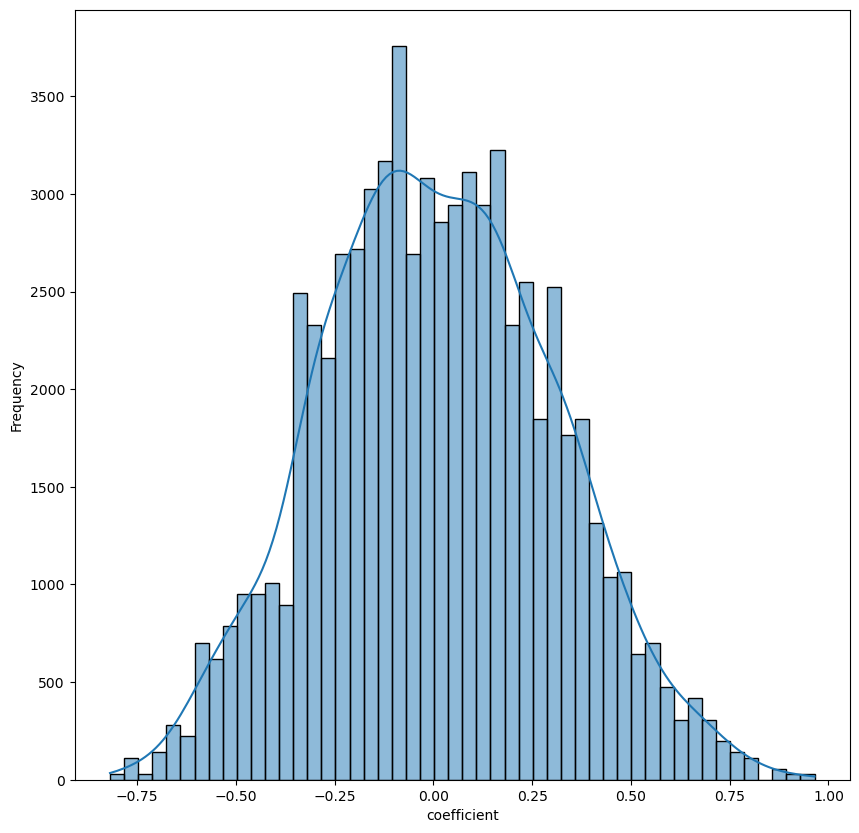

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=coefficients_copy, x='coefficient', ax=ax, bins=50, stat='frequency', kde=True)


In [16]:
number_of_sd = 2.5
upper_threshold = mean + number_of_sd*std
lower_threshold = mean - number_of_sd*std
print(upper_threshold, lower_threshold)

0.7464073296578053 -0.7268186485807033


In [17]:
above = coefficients_copy[coefficients_copy["coefficient"] > upper_threshold]
below = coefficients_copy[coefficients_copy["coefficient"] < lower_threshold]
above = above.sort_values("coefficient", ascending=False)
below = below.sort_values("coefficient", ascending=True)
print(len(above)+len(below))
above = above.head(100)
below = below.head(100)
all = pd.concat([above, below])
all.to_csv(root/"most_correlated.csv")

20
